In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2021-08-16 16:47:46.769928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-16 16:47:46.769953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.__version__)

2.5.0


In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file('stack_overflow_16k', url,
                                  untar=True, cache_subdir='/home/leno/.keras/datasets/stack_overflow')
dataset_dir = os.path.dirname(dataset)

In [4]:
os.listdir(os.path.dirname(dataset))

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [5]:
dataset_dir

'/home/leno/.keras/datasets/stack_overflow'

In [6]:
train_dir = os.path.join(dataset_dir, 'train')

In [7]:
os.listdir(train_dir)

['java', 'csharp', 'python', 'javascript']

In [8]:
sample_file = os.path.join(train_dir, 'python/1132.txt')
with open(sample_file) as f:
    print(f.read())

"are there objects that cannot be coerced into a string in blank? in blank, can any object be coerced into a string unless its __str__ method is overloaded to raise an exception?"



In [9]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(train_dir,
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2021-08-16 16:47:49.996228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-16 16:47:49.996251: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-16 16:47:49.996304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leno-lab): /proc/driver/nvidia/version does not exist
2021-08-16 16:47:49.996559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

2021-08-16 16:47:50.027320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 16:47:50.043061: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3194440000 Hz


In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [12]:
test_dir = os.path.join(dataset_dir, 'test')

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(train_dir,
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(test_dir,
                                                                 batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [15]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_char = tf.strings.regex_replace(lowercase, r'([^a-zA-Z]+)(\s+)', ' ')
    no_char = tf.strings.strip(no_char)
    return tf.strings.regex_replace(no_char, '[%s]' % re.escape(string.punctuation), ' ')

In [16]:
max_features = 15000
sequence_length = 1000
vectorize_layer = TextVectorization(standardize=custom_standardization,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=sequence_length)

In [17]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[1], label_batch[1]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'"how do i convert a binary image into an in-memory data structure in blank? context: ...i am using blank 2.6.5...goal:...read a binary image file and represent it in-memory. then run a checksum on it. deliver the binary representation to be stored as a blob in mysql....comments:...i have read this so thread..i have looked at the struct module. .i also have bumped into the io module..with all the available options, i am not certain which is the best solution. the bytesio data structure seems to be suitable for my needs. which one do you think will meet my requirements ?"\n', shape=(), dtype=string)
Label python
Vectorized review (<tf.Tensor: shape=(1, 1000), dtype=int64, numpy=
array([[   27,    53,     2,   224,     5,   915,   207,   143,    46,
            9,   722,    62,   876,     9,    15,   752,     2,    49,
           54,    15,   121,   347,   254,  1421,   171,     5,   915,
          207,    34,    10,  2414,    14,     9,   722,   113,   159,
           

In [20]:
print("1333 ---> ", vectorize_layer.get_vocabulary()[1333])
print(" 333 ---> ", vectorize_layer.get_vocabulary()[333])
print('Vocabulary Size: {}'.format(len(vectorize_layer.get_vocabulary())))

1333 --->  including
 333 --->  tolowercase
Vocabulary Size: 15000


In [21]:
vectorize_layer.get_vocabulary()[-1]

'flaw'

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(4)])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          240016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2

In [27]:
def get_optimizer():
    return tf.keras.optimizers.Adam()

In [28]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
        tf.keras.callbacks.TensorBoard('/tmp/tensorboard')
    ]

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=get_optimizer(),
              metrics=['accuracy'])

In [30]:
epochs = 300
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=get_callbacks(),
                    verbose=0)

2021-08-16 16:47:51.543483: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-16 16:47:51.543514: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-16 16:47:51.545879: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-16 16:47:52.144601: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-16 16:47:52.144633: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-16 16:47:52.158877: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-16 16:47:52.161441: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-16 16:47:52.165000: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/tensorboard/train/plugins/profile/2021_08_16_16_47_52
2021-08-16 16:47:52.167352: I tensorflow/co

In [31]:
loss, accuracy = model.evaluate(test_ds)

250/250 [==============================] - 1s 4ms/step - loss: 0.7448 - accuracy: 0.7602


In [32]:
print("Loss:", loss)
print("Accuracy", accuracy)

Loss: 0.7448259592056274
Accuracy 0.7602499723434448


In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

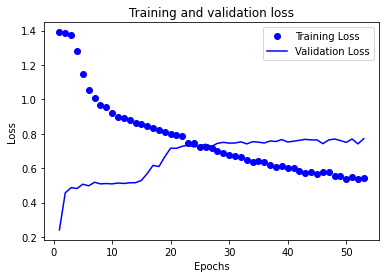

In [34]:
acc = history_dict['accuracy']
val_cc = history_dict['val_loss']
loss = history_dict['loss']
val_loss = history_dict['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

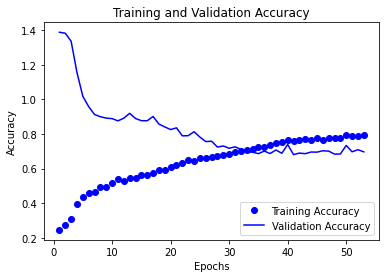

In [35]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_cc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [36]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

In [37]:
export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                     optimizer=get_optimizer(), metrics=['accuracy'])

In [38]:
loss, accuracy = export_model.evaluate(raw_test_ds)

250/250 [==============================] - 1s 5ms/step - loss: 0.7448 - accuracy: 0.7602


In [39]:
example = ['What is the way in python to sort a list?']

In [40]:
pred = export_model.predict(example)

In [41]:
pred

array([[0.66269606, 0.38647625, 0.2674225 , 0.22305778]], dtype=float32)

In [42]:
pred_idx = np.where(pred == np.amax(pred))

In [43]:
pred_idx

(array([0]), array([0]))

In [44]:
raw_train_ds.class_names[pred_idx[1].take(0)]

'csharp'